# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

In [1]:
pre_seq_length = 10
aft_seq_length = 1

In [8]:
import os
from scenedetect import detect, ContentDetector, split_video_ffmpeg
dataset = "/home/jaslap/OpenSTL/data/gaze_test/"
folders = ['train', 'val', 'test']
for folder in folders:
    folder_path = os.path.join(dataset, folder)
    files = os.listdir(folder_path)
    for file in files:
        if file.endswith(".mp4"):
            os.remove(os.path.join(folder_path, file))
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        scene_list = detect(video_path, ContentDetector(threshold=20))
        split_video_ffmpeg(video_path, scene_list, output_dir=folder_path)

/home/jaslap/.conda/envs/OpenSTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import cv2
import numpy as np
import os

def sample_frames(video_path, num_frames=20):
    # read the video
    video = cv2.VideoCapture(video_path)
    # uniformly sample frames from the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        suc, frame = video.read()
        if not suc:
            print('Error reading video frame')
            break
        frame = cv2.resize(frame, (160, 128))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # get all the videos in this folder
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # stack video frames from each folder
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # if the data is in [0, 255], rescale it into [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

In [10]:
import pickle

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    data_x, data_y = process_folder("../data/gaze_test/" + folder, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.mp4')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# save as a pkl file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

### 1.2 Load the dataset and visualize an example

In [2]:
import pickle

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channel, height, width of each frame

(1532, 10, 3, 128, 160)


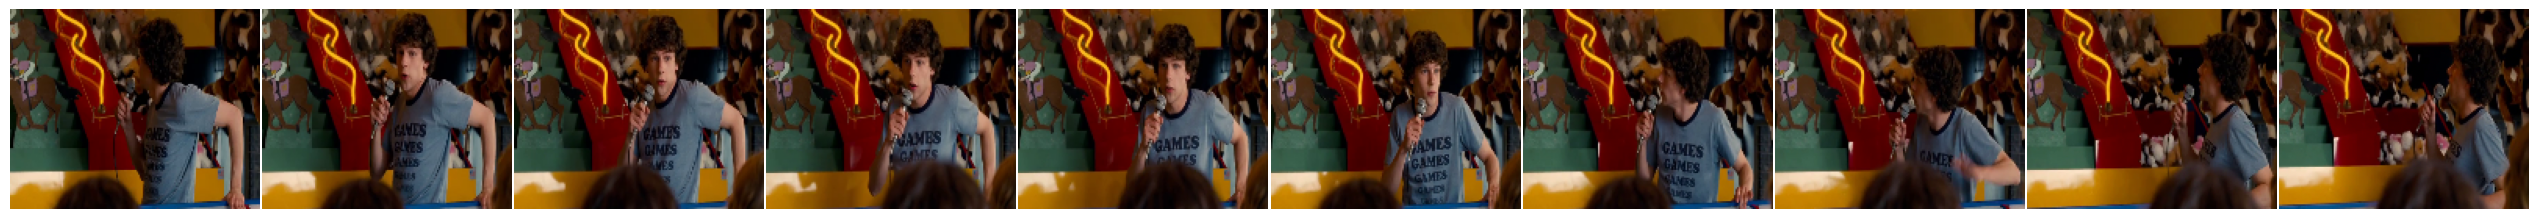

In [12]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 4
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

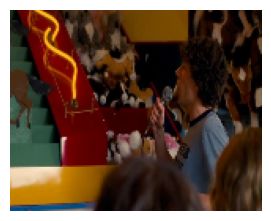

In [13]:
# show the future frames from an example
example_idx = 4
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [3]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name='custom'):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [4]:
batch_size = 4

In [5]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [6]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [7]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 1000,
    'lr': 0.001,   
    'metrics': ['mse', 'mae'],
    'gpus': [4],
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [10, 3, 128, 160],
}
custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [8]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

torch.cuda.empty_cache()
exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

/home/jaslap/.conda/envs/OpenSTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [9]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

print('>'*35 + ' testing  ' + '<'*35)
exp.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type        | Params
------------------------------------------
0 | model     | SimVP_Model | 18.6 M
1 | criterion | MSELoss     | 0     
------------------------------------------
18.6 M    Trainable params
0         Non-trainable params
18.6 M    Total params
74.417    Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
CUDA available: True
CUDA_HOME: /usr
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0,1,2,3,4,5,6,7,8,9: Quadro RTX 6000
GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
PyTorch: 2.2.2+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.1-Product Build 20220311 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm

Epoch 0: 100%|██████████| 464/464 [01:19<00:00,  5.81it/s, loss=0.0275, v_num=44, train_loss_step=0.0307, train_loss_epoch=0.0327]

Epoch 0, global step 383: 'val_loss' reached 0.02297 (best 0.02297), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=0.023.ckpt' as top 1


Epoch 1: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.0267, v_num=44, train_loss_step=0.041, train_loss_epoch=0.0238]

Epoch 1, global step 766: 'val_loss' reached 0.02053 (best 0.02053), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=0.021.ckpt' as top 1


Epoch 2: 100%|██████████| 464/464 [01:19<00:00,  5.85it/s, loss=0.0179, v_num=44, train_loss_step=0.037, train_loss_epoch=0.0218]

Epoch 2, global step 1149: 'val_loss' reached 0.01976 (best 0.01976), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=0.020.ckpt' as top 1


Epoch 3: 100%|██████████| 464/464 [01:19<00:00,  5.87it/s, loss=0.0235, v_num=44, train_loss_step=0.0157, train_loss_epoch=0.0213]

Epoch 3, global step 1532: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 464/464 [01:18<00:00,  5.90it/s, loss=0.0192, v_num=44, train_loss_step=0.0115, train_loss_epoch=0.0209]

Epoch 4, global step 1915: 'val_loss' reached 0.01949 (best 0.01949), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=04-val_loss=0.019.ckpt' as top 1


Epoch 5: 100%|██████████| 464/464 [01:18<00:00,  5.89it/s, loss=0.0221, v_num=44, train_loss_step=0.0341, train_loss_epoch=0.0206]

Epoch 5, global step 2298: 'val_loss' reached 0.01834 (best 0.01834), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=05-val_loss=0.018.ckpt' as top 1


Epoch 6: 100%|██████████| 464/464 [01:19<00:00,  5.87it/s, loss=0.0169, v_num=44, train_loss_step=0.00513, train_loss_epoch=0.0203]

Epoch 6, global step 2681: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 464/464 [01:18<00:00,  5.90it/s, loss=0.0179, v_num=44, train_loss_step=0.00552, train_loss_epoch=0.0199]

Epoch 7, global step 3064: 'val_loss' reached 0.01832 (best 0.01832), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=07-val_loss=0.018.ckpt' as top 1


Epoch 8: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0251, v_num=44, train_loss_step=0.032, train_loss_epoch=0.0198]

Epoch 8, global step 3447: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 464/464 [01:19<00:00,  5.87it/s, loss=0.0221, v_num=44, train_loss_step=0.0108, train_loss_epoch=0.0195]

Epoch 9, global step 3830: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 464/464 [01:18<00:00,  5.89it/s, loss=0.0202, v_num=44, train_loss_step=0.0148, train_loss_epoch=0.0193]

Epoch 10, global step 4213: 'val_loss' reached 0.01821 (best 0.01821), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=10-val_loss=0.018.ckpt' as top 1


Epoch 11: 100%|██████████| 464/464 [01:19<00:00,  5.87it/s, loss=0.0221, v_num=44, train_loss_step=0.0189, train_loss_epoch=0.0194]

Epoch 11, global step 4596: 'val_loss' was not in top 1


Epoch 12: 100%|██████████| 464/464 [01:18<00:00,  5.90it/s, loss=0.0162, v_num=44, train_loss_step=0.00958, train_loss_epoch=0.0187]

Epoch 12, global step 4979: 'val_loss' reached 0.01759 (best 0.01759), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=12-val_loss=0.018-v2.ckpt' as top 1


Epoch 13: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.0163, v_num=44, train_loss_step=0.0103, train_loss_epoch=0.0184]

Epoch 13, global step 5362: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 464/464 [01:18<00:00,  5.90it/s, loss=0.02, v_num=44, train_loss_step=0.0158, train_loss_epoch=0.0181]

Epoch 14, global step 5745: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 464/464 [01:18<00:00,  5.90it/s, loss=0.0189, v_num=44, train_loss_step=0.0197, train_loss_epoch=0.0179]

Epoch 15, global step 6128: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 464/464 [01:18<00:00,  5.89it/s, loss=0.0149, v_num=44, train_loss_step=0.00982, train_loss_epoch=0.0175]

Epoch 16, global step 6511: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 464/464 [01:18<00:00,  5.89it/s, loss=0.0166, v_num=44, train_loss_step=0.0142, train_loss_epoch=0.0169]

Epoch 17, global step 6894: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0185, v_num=44, train_loss_step=0.0192, train_loss_epoch=0.0165]

Epoch 18, global step 7277: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0176, v_num=44, train_loss_step=0.014, train_loss_epoch=0.0158]

Epoch 19, global step 7660: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0143, v_num=44, train_loss_step=0.0139, train_loss_epoch=0.0156]

Epoch 20, global step 8043: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.0149, v_num=44, train_loss_step=0.016, train_loss_epoch=0.0151]

Epoch 21, global step 8426: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 464/464 [01:18<00:00,  5.87it/s, loss=0.0132, v_num=44, train_loss_step=0.0119, train_loss_epoch=0.0144]

Epoch 22, global step 8809: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0143, v_num=44, train_loss_step=0.0268, train_loss_epoch=0.0142]

Epoch 23, global step 9192: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 464/464 [01:19<00:00,  5.87it/s, loss=0.016, v_num=44, train_loss_step=0.013, train_loss_epoch=0.0138]

Epoch 24, global step 9575: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s, loss=0.0129, v_num=44, train_loss_step=0.00844, train_loss_epoch=0.013] 

Epoch 25, global step 9958: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 464/464 [01:18<00:00,  5.88it/s, loss=0.0113, v_num=44, train_loss_step=0.00529, train_loss_epoch=0.0128]

Epoch 26, global step 10341: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.01, v_num=44, train_loss_step=0.024, train_loss_epoch=0.0124]

Epoch 27, global step 10724: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.0127, v_num=44, train_loss_step=0.0113, train_loss_epoch=0.0126]

Epoch 28, global step 11107: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.0124, v_num=44, train_loss_step=0.00594, train_loss_epoch=0.0119]

Epoch 29, global step 11490: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 464/464 [01:19<00:00,  5.86it/s, loss=0.0142, v_num=44, train_loss_step=0.0137, train_loss_epoch=0.0114]

Epoch 30, global step 11873: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 464/464 [01:19<00:00,  5.85it/s, loss=0.0131, v_num=44, train_loss_step=0.00965, train_loss_epoch=0.0115]

Epoch 31, global step 12256: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 464/464 [01:19<00:00,  5.84it/s, loss=0.0107, v_num=44, train_loss_step=0.0128, train_loss_epoch=0.0113]

Epoch 32, global step 12639: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s, loss=0.00869, v_num=44, train_loss_step=0.00571, train_loss_epoch=0.0104]

Epoch 33, global step 13022: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 464/464 [01:19<00:00,  5.84it/s, loss=0.0122, v_num=44, train_loss_step=0.0093, train_loss_epoch=0.0107]

Epoch 34, global step 13405: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 464/464 [01:19<00:00,  5.85it/s, loss=0.0104, v_num=44, train_loss_step=0.00828, train_loss_epoch=0.0104]

Epoch 35, global step 13788: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 464/464 [01:19<00:00,  5.84it/s, loss=0.0104, v_num=44, train_loss_step=0.00621, train_loss_epoch=0.00974]

Epoch 36, global step 14171: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 464/464 [01:19<00:00,  5.84it/s, loss=0.00974, v_num=44, train_loss_step=0.0158, train_loss_epoch=0.00989]

Epoch 37, global step 14554: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 464/464 [01:20<00:00,  5.76it/s, loss=0.00812, v_num=44, train_loss_step=0.00708, train_loss_epoch=0.00924]

Epoch 38, global step 14937: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00894, v_num=44, train_loss_step=0.00702, train_loss_epoch=0.00912]

Epoch 39, global step 15320: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s, loss=0.00841, v_num=44, train_loss_step=0.00621, train_loss_epoch=0.00917]

Epoch 40, global step 15703: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s, loss=0.00969, v_num=44, train_loss_step=0.0063, train_loss_epoch=0.00901]

Epoch 41, global step 16086: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s, loss=0.00863, v_num=44, train_loss_step=0.00701, train_loss_epoch=0.00862]

Epoch 42, global step 16469: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 464/464 [01:19<00:00,  5.82it/s, loss=0.00754, v_num=44, train_loss_step=0.00566, train_loss_epoch=0.00856]

Epoch 43, global step 16852: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 464/464 [01:19<00:00,  5.82it/s, loss=0.0105, v_num=44, train_loss_step=0.0165, train_loss_epoch=0.0083] 

Epoch 44, global step 17235: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 464/464 [01:19<00:00,  5.81it/s, loss=0.00755, v_num=44, train_loss_step=0.0136, train_loss_epoch=0.00821]

Epoch 45, global step 17618: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 464/464 [01:19<00:00,  5.81it/s, loss=0.00828, v_num=44, train_loss_step=0.0106, train_loss_epoch=0.00776]

Epoch 46, global step 18001: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 464/464 [01:19<00:00,  5.82it/s, loss=0.00822, v_num=44, train_loss_step=0.00489, train_loss_epoch=0.0077] 

Epoch 47, global step 18384: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 464/464 [01:19<00:00,  5.81it/s, loss=0.00759, v_num=44, train_loss_step=0.0116, train_loss_epoch=0.00782]

Epoch 48, global step 18767: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 464/464 [01:19<00:00,  5.80it/s, loss=0.00753, v_num=44, train_loss_step=0.00494, train_loss_epoch=0.00778]

Epoch 49, global step 19150: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 464/464 [01:19<00:00,  5.80it/s, loss=0.00962, v_num=44, train_loss_step=0.00953, train_loss_epoch=0.00785]

Epoch 50, global step 19533: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00854, v_num=44, train_loss_step=0.00642, train_loss_epoch=0.00812]

Epoch 51, global step 19916: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 464/464 [01:19<00:00,  5.81it/s, loss=0.00673, v_num=44, train_loss_step=0.00696, train_loss_epoch=0.00709]

Epoch 52, global step 20299: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 464/464 [01:19<00:00,  5.80it/s, loss=0.00855, v_num=44, train_loss_step=0.010, train_loss_epoch=0.00827]

Epoch 53, global step 20682: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00754, v_num=44, train_loss_step=0.00761, train_loss_epoch=0.00714]

Epoch 54, global step 21065: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00748, v_num=44, train_loss_step=0.00751, train_loss_epoch=0.00671]

Epoch 55, global step 21448: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 464/464 [01:20<00:00,  5.78it/s, loss=0.00749, v_num=44, train_loss_step=0.00688, train_loss_epoch=0.00678]

Epoch 56, global step 21831: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 464/464 [01:20<00:00,  5.78it/s, loss=0.00583, v_num=44, train_loss_step=0.00633, train_loss_epoch=0.00655]

Epoch 57, global step 22214: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 464/464 [01:20<00:00,  5.80it/s, loss=0.00648, v_num=44, train_loss_step=0.00312, train_loss_epoch=0.00639]

Epoch 58, global step 22597: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.0077, v_num=44, train_loss_step=0.00724, train_loss_epoch=0.00673]

Epoch 59, global step 22980: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00601, v_num=44, train_loss_step=0.00527, train_loss_epoch=0.00701]

Epoch 60, global step 23363: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 464/464 [01:20<00:00,  5.79it/s, loss=0.00563, v_num=44, train_loss_step=0.00431, train_loss_epoch=0.00639]

Epoch 61, global step 23746: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.00578, v_num=44, train_loss_step=0.003, train_loss_epoch=0.00606]

Epoch 62, global step 24129: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 464/464 [01:20<00:00,  5.76it/s, loss=0.00679, v_num=44, train_loss_step=0.00692, train_loss_epoch=0.00618]

Epoch 63, global step 24512: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 464/464 [01:20<00:00,  5.78it/s, loss=0.00632, v_num=44, train_loss_step=0.00934, train_loss_epoch=0.00624]

Epoch 64, global step 24895: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.00629, v_num=44, train_loss_step=0.00338, train_loss_epoch=0.00675]

Epoch 65, global step 25278: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.00553, v_num=44, train_loss_step=0.00307, train_loss_epoch=0.00595]

Epoch 66, global step 25661: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 464/464 [01:20<00:00,  5.77it/s, loss=0.0047, v_num=44, train_loss_step=0.00651, train_loss_epoch=0.00581]

Epoch 67, global step 26044: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 464/464 [01:20<00:00,  5.76it/s, loss=0.00535, v_num=44, train_loss_step=0.00395, train_loss_epoch=0.00567]

Epoch 68, global step 26427: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 464/464 [01:20<00:00,  5.75it/s, loss=0.00601, v_num=44, train_loss_step=0.00655, train_loss_epoch=0.00564]

Epoch 69, global step 26810: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 464/464 [01:20<00:00,  5.76it/s, loss=0.00553, v_num=44, train_loss_step=0.00471, train_loss_epoch=0.00581]

Epoch 70, global step 27193: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 464/464 [01:20<00:00,  5.75it/s, loss=0.00524, v_num=44, train_loss_step=0.00515, train_loss_epoch=0.00542]

Epoch 71, global step 27576: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 464/464 [01:20<00:00,  5.76it/s, loss=0.00488, v_num=44, train_loss_step=0.00342, train_loss_epoch=0.0054] 

Epoch 72, global step 27959: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 464/464 [01:20<00:00,  5.75it/s, loss=0.00592, v_num=44, train_loss_step=0.00988, train_loss_epoch=0.00512]

Epoch 73, global step 28342: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 464/464 [01:20<00:00,  5.74it/s, loss=0.00528, v_num=44, train_loss_step=0.00437, train_loss_epoch=0.00558]

Epoch 74, global step 28725: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 464/464 [01:20<00:00,  5.74it/s, loss=0.0108, v_num=44, train_loss_step=0.00812, train_loss_epoch=0.00917]

Epoch 75, global step 29108: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00772, v_num=44, train_loss_step=0.00315, train_loss_epoch=0.00654]

Epoch 76, global step 29491: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 464/464 [01:20<00:00,  5.74it/s, loss=0.00512, v_num=44, train_loss_step=0.00295, train_loss_epoch=0.00565]

Epoch 77, global step 29874: 'val_loss' was not in top 1


Epoch 78: 100%|██████████| 464/464 [01:20<00:00,  5.73it/s, loss=0.00565, v_num=44, train_loss_step=0.00801, train_loss_epoch=0.00481]

Epoch 78, global step 30257: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00437, v_num=44, train_loss_step=0.00762, train_loss_epoch=0.00464]

Epoch 79, global step 30640: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 464/464 [01:20<00:00,  5.73it/s, loss=0.00435, v_num=44, train_loss_step=0.0039, train_loss_epoch=0.00452]

Epoch 80, global step 31023: 'val_loss' was not in top 1


Epoch 81: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00433, v_num=44, train_loss_step=0.00497, train_loss_epoch=0.0046] 

Epoch 81, global step 31406: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 464/464 [01:21<00:00,  5.71it/s, loss=0.00897, v_num=44, train_loss_step=0.00781, train_loss_epoch=0.00597]

Epoch 82, global step 31789: 'val_loss' was not in top 1


Epoch 83: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00506, v_num=44, train_loss_step=0.00373, train_loss_epoch=0.00609]

Epoch 83, global step 32172: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 464/464 [01:21<00:00,  5.72it/s, loss=0.0053, v_num=44, train_loss_step=0.00772, train_loss_epoch=0.0048] 

Epoch 84, global step 32555: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 464/464 [01:21<00:00,  5.73it/s, loss=0.00404, v_num=44, train_loss_step=0.006, train_loss_epoch=0.00436]

Epoch 85, global step 32938: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 464/464 [01:21<00:00,  5.72it/s, loss=0.00415, v_num=44, train_loss_step=0.00355, train_loss_epoch=0.0046] 

Epoch 86, global step 33321: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 464/464 [01:21<00:00,  5.71it/s, loss=0.00534, v_num=44, train_loss_step=0.00184, train_loss_epoch=0.00492]

Epoch 87, global step 33704: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 464/464 [01:21<00:00,  5.72it/s, loss=0.00567, v_num=44, train_loss_step=0.00277, train_loss_epoch=0.00528]

Epoch 88, global step 34087: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 464/464 [01:21<00:00,  5.72it/s, loss=0.0053, v_num=44, train_loss_step=0.00428, train_loss_epoch=0.00498]

Epoch 89, global step 34470: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00387, v_num=44, train_loss_step=0.00739, train_loss_epoch=0.00449]

Epoch 90, global step 34853: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00533, v_num=44, train_loss_step=0.00656, train_loss_epoch=0.00434]

Epoch 91, global step 35236: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00467, v_num=44, train_loss_step=0.00752, train_loss_epoch=0.00435]

Epoch 92, global step 35619: 'val_loss' was not in top 1


Epoch 93: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00459, v_num=44, train_loss_step=0.00351, train_loss_epoch=0.00434]

Epoch 93, global step 36002: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.00501, v_num=44, train_loss_step=0.00485, train_loss_epoch=0.00422]

Epoch 94, global step 36385: 'val_loss' was not in top 1


Epoch 95: 100%|██████████| 464/464 [01:21<00:00,  5.70it/s, loss=0.0042, v_num=44, train_loss_step=0.00462, train_loss_epoch=0.00447]

Epoch 95, global step 36768: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00463, v_num=44, train_loss_step=0.00307, train_loss_epoch=0.00473]

Epoch 96, global step 37151: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00545, v_num=44, train_loss_step=0.00425, train_loss_epoch=0.00498]

Epoch 97, global step 37534: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 464/464 [01:21<00:00,  5.66it/s, loss=0.00464, v_num=44, train_loss_step=0.0033, train_loss_epoch=0.00515]

Epoch 98, global step 37917: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 464/464 [01:21<00:00,  5.67it/s, loss=0.00473, v_num=44, train_loss_step=0.00554, train_loss_epoch=0.00445]

Epoch 99, global step 38300: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 464/464 [01:21<00:00,  5.69it/s, loss=0.00396, v_num=44, train_loss_step=0.00354, train_loss_epoch=0.00399]

Epoch 100, global step 38683: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 464/464 [01:22<00:00,  5.65it/s, loss=0.00318, v_num=44, train_loss_step=0.00201, train_loss_epoch=0.00376]

Epoch 101, global step 39066: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 464/464 [01:21<00:00,  5.67it/s, loss=0.00368, v_num=44, train_loss_step=0.00375, train_loss_epoch=0.00378]

Epoch 102, global step 39449: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 464/464 [01:21<00:00,  5.68it/s, loss=0.00532, v_num=44, train_loss_step=0.00562, train_loss_epoch=0.00439]

Epoch 103, global step 39832: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 464/464 [01:21<00:00,  5.67it/s, loss=0.00426, v_num=44, train_loss_step=0.00353, train_loss_epoch=0.00446]

Epoch 104, global step 40215: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 464/464 [01:21<00:00,  5.68it/s, loss=0.00361, v_num=44, train_loss_step=0.00322, train_loss_epoch=0.00406]

Epoch 105, global step 40598: 'val_loss' was not in top 1


Epoch 106: 100%|██████████| 464/464 [01:21<00:00,  5.66it/s, loss=0.00344, v_num=44, train_loss_step=0.00528, train_loss_epoch=0.0038] 

Epoch 106, global step 40981: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 464/464 [01:21<00:00,  5.66it/s, loss=0.00516, v_num=44, train_loss_step=0.00594, train_loss_epoch=0.00392]

Epoch 107, global step 41364: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 464/464 [01:22<00:00,  5.66it/s, loss=0.00524, v_num=44, train_loss_step=0.00469, train_loss_epoch=0.00601]

Epoch 108, global step 41747: 'val_loss' was not in top 1


Epoch 109: 100%|██████████| 464/464 [01:22<00:00,  5.62it/s, loss=0.00367, v_num=44, train_loss_step=0.00416, train_loss_epoch=0.0043] 

Epoch 109, global step 42130: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 464/464 [01:21<00:00,  5.66it/s, loss=0.00378, v_num=44, train_loss_step=0.00645, train_loss_epoch=0.00368]

Epoch 110, global step 42513: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 464/464 [01:22<00:00,  5.66it/s, loss=0.00412, v_num=44, train_loss_step=0.00265, train_loss_epoch=0.00352]

Epoch 111, global step 42896: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 464/464 [01:21<00:00,  5.66it/s, loss=0.00404, v_num=44, train_loss_step=0.00254, train_loss_epoch=0.00393]

Epoch 112, global step 43279: 'val_loss' was not in top 1


Epoch 113: 100%|██████████| 464/464 [01:22<00:00,  5.65it/s, loss=0.00377, v_num=44, train_loss_step=0.00333, train_loss_epoch=0.00356]

Epoch 113, global step 43662: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 464/464 [01:22<00:00,  5.65it/s, loss=0.00448, v_num=44, train_loss_step=0.00657, train_loss_epoch=0.00374]

Epoch 114, global step 44045: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 464/464 [01:22<00:00,  5.64it/s, loss=0.00406, v_num=44, train_loss_step=0.00288, train_loss_epoch=0.00405]

Epoch 115, global step 44428: 'val_loss' was not in top 1


Epoch 116: 100%|██████████| 464/464 [01:22<00:00,  5.62it/s, loss=0.00389, v_num=44, train_loss_step=0.00426, train_loss_epoch=0.00542]

Epoch 116, global step 44811: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 464/464 [01:22<00:00,  5.64it/s, loss=0.00415, v_num=44, train_loss_step=0.00201, train_loss_epoch=0.00438]

Epoch 117, global step 45194: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 464/464 [01:22<00:00,  5.63it/s, loss=0.00393, v_num=44, train_loss_step=0.00227, train_loss_epoch=0.00347]

Epoch 118, global step 45577: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 464/464 [01:22<00:00,  5.63it/s, loss=0.00419, v_num=44, train_loss_step=0.00171, train_loss_epoch=0.00324]

Epoch 119, global step 45960: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 464/464 [01:22<00:00,  5.61it/s, loss=0.00352, v_num=44, train_loss_step=0.00302, train_loss_epoch=0.00321]

Epoch 120, global step 46343: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00393, v_num=44, train_loss_step=0.00267, train_loss_epoch=0.00331]

Epoch 121, global step 46726: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 464/464 [01:22<00:00,  5.63it/s, loss=0.00421, v_num=44, train_loss_step=0.00292, train_loss_epoch=0.00354]

Epoch 122, global step 47109: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 464/464 [01:23<00:00,  5.58it/s, loss=0.00492, v_num=44, train_loss_step=0.00222, train_loss_epoch=0.00379]

Epoch 123, global step 47492: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00757, v_num=44, train_loss_step=0.0131, train_loss_epoch=0.00929]

Epoch 124, global step 47875: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00434, v_num=44, train_loss_step=0.00521, train_loss_epoch=0.00641]

Epoch 125, global step 48258: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 464/464 [01:22<00:00,  5.62it/s, loss=0.0036, v_num=44, train_loss_step=0.00366, train_loss_epoch=0.00389]

Epoch 126, global step 48641: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 464/464 [01:22<00:00,  5.61it/s, loss=0.0029, v_num=44, train_loss_step=0.00306, train_loss_epoch=0.00319]

Epoch 127, global step 49024: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 464/464 [01:23<00:00,  5.59it/s, loss=0.00342, v_num=44, train_loss_step=0.00193, train_loss_epoch=0.00298]

Epoch 128, global step 49407: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.0031, v_num=44, train_loss_step=0.00254, train_loss_epoch=0.00301]

Epoch 129, global step 49790: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 464/464 [01:23<00:00,  5.58it/s, loss=0.00403, v_num=44, train_loss_step=0.00328, train_loss_epoch=0.00309]

Epoch 130, global step 50173: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 464/464 [01:22<00:00,  5.61it/s, loss=0.0032, v_num=44, train_loss_step=0.00423, train_loss_epoch=0.00332]

Epoch 131, global step 50556: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00295, v_num=44, train_loss_step=0.00177, train_loss_epoch=0.00333]

Epoch 132, global step 50939: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 464/464 [01:23<00:00,  5.58it/s, loss=0.00437, v_num=44, train_loss_step=0.00631, train_loss_epoch=0.00391]

Epoch 133, global step 51322: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.0033, v_num=44, train_loss_step=0.00424, train_loss_epoch=0.00361]

Epoch 134, global step 51705: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 464/464 [01:22<00:00,  5.61it/s, loss=0.00389, v_num=44, train_loss_step=0.00274, train_loss_epoch=0.00381]

Epoch 135, global step 52088: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 464/464 [01:22<00:00,  5.59it/s, loss=0.00274, v_num=44, train_loss_step=0.00245, train_loss_epoch=0.00379]

Epoch 136, global step 52471: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00315, v_num=44, train_loss_step=0.0024, train_loss_epoch=0.00337]

Epoch 137, global step 52854: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 464/464 [01:22<00:00,  5.60it/s, loss=0.00297, v_num=44, train_loss_step=0.0034, train_loss_epoch=0.00316]

Epoch 138, global step 53237: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 464/464 [01:23<00:00,  5.57it/s, loss=0.00755, v_num=44, train_loss_step=0.00553, train_loss_epoch=0.00363]

Epoch 139, global step 53620: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 464/464 [01:23<00:00,  5.58it/s, loss=0.0115, v_num=44, train_loss_step=0.00985, train_loss_epoch=0.0193] 

Epoch 140, global step 54003: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 464/464 [01:23<00:00,  5.54it/s, loss=0.00553, v_num=44, train_loss_step=0.00449, train_loss_epoch=0.00703]

Epoch 141, global step 54386: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 464/464 [01:23<00:00,  5.57it/s, loss=0.00413, v_num=44, train_loss_step=0.00606, train_loss_epoch=0.00423]

Epoch 142, global step 54769: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 464/464 [01:23<00:00,  5.57it/s, loss=0.00321, v_num=44, train_loss_step=0.00355, train_loss_epoch=0.00335]

Epoch 143, global step 55152: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 464/464 [01:23<00:00,  5.56it/s, loss=0.00279, v_num=44, train_loss_step=0.000875, train_loss_epoch=0.00313]

Epoch 144, global step 55535: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 464/464 [01:23<00:00,  5.55it/s, loss=0.00264, v_num=44, train_loss_step=0.00219, train_loss_epoch=0.00293]

Epoch 145, global step 55918: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 464/464 [01:23<00:00,  5.57it/s, loss=0.00338, v_num=44, train_loss_step=0.00208, train_loss_epoch=0.00283]

Epoch 146, global step 56301: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 464/464 [01:24<00:00,  5.47it/s, loss=0.00286, v_num=44, train_loss_step=0.00181, train_loss_epoch=0.00285]

Epoch 147, global step 56684: 'val_loss' was not in top 1


Epoch 148: 100%|██████████| 464/464 [01:23<00:00,  5.55it/s, loss=0.00253, v_num=44, train_loss_step=0.00298, train_loss_epoch=0.003]  

Epoch 148, global step 57067: 'val_loss' was not in top 1


Epoch 149: 100%|██████████| 464/464 [01:23<00:00,  5.56it/s, loss=0.00372, v_num=44, train_loss_step=0.00312, train_loss_epoch=0.00315]

Epoch 149, global step 57450: 'val_loss' was not in top 1


Epoch 150: 100%|██████████| 464/464 [01:23<00:00,  5.56it/s, loss=0.00322, v_num=44, train_loss_step=0.00301, train_loss_epoch=0.00337]

Epoch 150, global step 57833: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00384, v_num=44, train_loss_step=0.0036, train_loss_epoch=0.00357]

Epoch 151, global step 58216: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 464/464 [01:23<00:00,  5.56it/s, loss=0.00327, v_num=44, train_loss_step=0.00142, train_loss_epoch=0.00396]

Epoch 152, global step 58599: 'val_loss' was not in top 1


Epoch 153: 100%|██████████| 464/464 [01:23<00:00,  5.54it/s, loss=0.00474, v_num=44, train_loss_step=0.00696, train_loss_epoch=0.00585]

Epoch 153, global step 58982: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 464/464 [01:23<00:00,  5.56it/s, loss=0.00348, v_num=44, train_loss_step=0.00446, train_loss_epoch=0.00403]

Epoch 154, global step 59365: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 464/464 [01:23<00:00,  5.54it/s, loss=0.00301, v_num=44, train_loss_step=0.00238, train_loss_epoch=0.0031] 

Epoch 155, global step 59748: 'val_loss' was not in top 1


Epoch 156: 100%|██████████| 464/464 [01:23<00:00,  5.54it/s, loss=0.00291, v_num=44, train_loss_step=0.00117, train_loss_epoch=0.00272]

Epoch 156, global step 60131: 'val_loss' was not in top 1


Epoch 157: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00226, v_num=44, train_loss_step=0.00213, train_loss_epoch=0.00261]

Epoch 157, global step 60514: 'val_loss' reached 0.01751 (best 0.01751), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=157-val_loss=0.018.ckpt' as top 1


Epoch 158: 100%|██████████| 464/464 [01:24<00:00,  5.48it/s, loss=0.00432, v_num=44, train_loss_step=0.00424, train_loss_epoch=0.00333]

Epoch 158, global step 60897: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 464/464 [01:24<00:00,  5.51it/s, loss=0.00323, v_num=44, train_loss_step=0.00201, train_loss_epoch=0.00345]

Epoch 159, global step 61280: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 464/464 [01:23<00:00,  5.53it/s, loss=0.00285, v_num=44, train_loss_step=0.00296, train_loss_epoch=0.00327]

Epoch 160, global step 61663: 'val_loss' was not in top 1


Epoch 161: 100%|██████████| 464/464 [01:23<00:00,  5.53it/s, loss=0.00296, v_num=44, train_loss_step=0.00284, train_loss_epoch=0.00305]

Epoch 161, global step 62046: 'val_loss' was not in top 1


Epoch 162: 100%|██████████| 464/464 [01:23<00:00,  5.53it/s, loss=0.00268, v_num=44, train_loss_step=0.00306, train_loss_epoch=0.00305]

Epoch 162, global step 62429: 'val_loss' was not in top 1


Epoch 163: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00278, v_num=44, train_loss_step=0.00437, train_loss_epoch=0.00308]

Epoch 163, global step 62812: 'val_loss' was not in top 1


Epoch 164: 100%|██████████| 464/464 [01:23<00:00,  5.54it/s, loss=0.0035, v_num=44, train_loss_step=0.00283, train_loss_epoch=0.00337]

Epoch 164, global step 63195: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00266, v_num=44, train_loss_step=0.00293, train_loss_epoch=0.00311]

Epoch 165, global step 63578: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 464/464 [01:24<00:00,  5.51it/s, loss=0.00294, v_num=44, train_loss_step=0.00162, train_loss_epoch=0.003]  

Epoch 166, global step 63961: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 464/464 [01:23<00:00,  5.53it/s, loss=0.00269, v_num=44, train_loss_step=0.00201, train_loss_epoch=0.00287]

Epoch 167, global step 64344: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00282, v_num=44, train_loss_step=0.00124, train_loss_epoch=0.00294]

Epoch 168, global step 64727: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 464/464 [01:24<00:00,  5.49it/s, loss=0.00312, v_num=44, train_loss_step=0.00246, train_loss_epoch=0.00299]

Epoch 169, global step 65110: 'val_loss' was not in top 1


Epoch 170: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00353, v_num=44, train_loss_step=0.00318, train_loss_epoch=0.00313]

Epoch 170, global step 65493: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 464/464 [01:23<00:00,  5.53it/s, loss=0.016, v_num=44, train_loss_step=0.0186, train_loss_epoch=0.00991]

Epoch 171, global step 65876: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 464/464 [01:24<00:00,  5.50it/s, loss=0.00556, v_num=44, train_loss_step=0.00771, train_loss_epoch=0.0084] 

Epoch 172, global step 66259: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 464/464 [01:24<00:00,  5.52it/s, loss=0.00531, v_num=44, train_loss_step=0.00249, train_loss_epoch=0.0043]

Epoch 173, global step 66642: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 464/464 [01:24<00:00,  5.50it/s, loss=0.00268, v_num=44, train_loss_step=0.00225, train_loss_epoch=0.00349]

Epoch 174, global step 67025: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 464/464 [01:24<00:00,  5.49it/s, loss=0.00327, v_num=44, train_loss_step=0.00274, train_loss_epoch=0.00284]

Epoch 175, global step 67408: 'val_loss' was not in top 1


Epoch 176: 100%|██████████| 464/464 [01:24<00:00,  5.48it/s, loss=0.00237, v_num=44, train_loss_step=0.00678, train_loss_epoch=0.00255]

Epoch 176, global step 67791: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 464/464 [01:24<00:00,  5.49it/s, loss=0.00278, v_num=44, train_loss_step=0.00189, train_loss_epoch=0.00247]

Epoch 177, global step 68174: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 464/464 [01:26<00:00,  5.35it/s, loss=0.00246, v_num=44, train_loss_step=0.00228, train_loss_epoch=0.00249]

Epoch 178, global step 68557: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 464/464 [01:24<00:00,  5.47it/s, loss=0.00239, v_num=44, train_loss_step=0.00232, train_loss_epoch=0.00263]

Epoch 179, global step 68940: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 464/464 [01:24<00:00,  5.48it/s, loss=0.00363, v_num=44, train_loss_step=0.00232, train_loss_epoch=0.0027] 

Epoch 180, global step 69323: 'val_loss' reached 0.01751 (best 0.01751), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=180-val_loss=0.018.ckpt' as top 1


Epoch 181: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00287, v_num=44, train_loss_step=0.00235, train_loss_epoch=0.00282]

Epoch 181, global step 69706: 'val_loss' was not in top 1


Epoch 182: 100%|██████████| 464/464 [01:24<00:00,  5.49it/s, loss=0.0027, v_num=44, train_loss_step=0.00186, train_loss_epoch=0.00278]

Epoch 182, global step 70089: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.00282, v_num=44, train_loss_step=0.00387, train_loss_epoch=0.00277]

Epoch 183, global step 70472: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 464/464 [01:24<00:00,  5.48it/s, loss=0.00262, v_num=44, train_loss_step=0.00112, train_loss_epoch=0.00294]

Epoch 184, global step 70855: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 464/464 [01:24<00:00,  5.48it/s, loss=0.00309, v_num=44, train_loss_step=0.0026, train_loss_epoch=0.0029] 

Epoch 185, global step 71238: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 464/464 [01:24<00:00,  5.47it/s, loss=0.00299, v_num=44, train_loss_step=0.00416, train_loss_epoch=0.0028]

Epoch 186, global step 71621: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00329, v_num=44, train_loss_step=0.00432, train_loss_epoch=0.00269]

Epoch 187, global step 72004: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 464/464 [01:25<00:00,  5.40it/s, loss=0.00291, v_num=44, train_loss_step=0.00402, train_loss_epoch=0.00266]

Epoch 188, global step 72387: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 464/464 [01:25<00:00,  5.45it/s, loss=0.00247, v_num=44, train_loss_step=0.00291, train_loss_epoch=0.00279]

Epoch 189, global step 72770: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00256, v_num=44, train_loss_step=0.00142, train_loss_epoch=0.00271]

Epoch 190, global step 73153: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 464/464 [01:25<00:00,  5.45it/s, loss=0.00264, v_num=44, train_loss_step=0.0015, train_loss_epoch=0.00268]

Epoch 191, global step 73536: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 464/464 [01:25<00:00,  5.45it/s, loss=0.00219, v_num=44, train_loss_step=0.00253, train_loss_epoch=0.00276]

Epoch 192, global step 73919: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 464/464 [01:24<00:00,  5.47it/s, loss=0.00233, v_num=44, train_loss_step=0.00449, train_loss_epoch=0.00271]

Epoch 193, global step 74302: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.00245, v_num=44, train_loss_step=0.000547, train_loss_epoch=0.0026] 

Epoch 194, global step 74685: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 464/464 [01:24<00:00,  5.46it/s, loss=0.00249, v_num=44, train_loss_step=0.00306, train_loss_epoch=0.00256]

Epoch 195, global step 75068: 'val_loss' reached 0.01751 (best 0.01751), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=195-val_loss=0.018.ckpt' as top 1


Epoch 196: 100%|██████████| 464/464 [01:26<00:00,  5.34it/s, loss=0.00237, v_num=44, train_loss_step=0.00123, train_loss_epoch=0.00262]

Epoch 196, global step 75451: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 464/464 [01:25<00:00,  5.46it/s, loss=0.0217, v_num=44, train_loss_step=0.0125, train_loss_epoch=0.00598]

Epoch 197, global step 75834: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 464/464 [01:25<00:00,  5.45it/s, loss=0.0145, v_num=44, train_loss_step=0.00751, train_loss_epoch=0.015]  

Epoch 198, global step 76217: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.00625, v_num=44, train_loss_step=0.00339, train_loss_epoch=0.00771]

Epoch 199, global step 76600: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 464/464 [01:25<00:00,  5.45it/s, loss=0.00372, v_num=44, train_loss_step=0.00472, train_loss_epoch=0.00418]

Epoch 200, global step 76983: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.00289, v_num=44, train_loss_step=0.00362, train_loss_epoch=0.00307]

Epoch 201, global step 77366: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.00253, v_num=44, train_loss_step=0.00314, train_loss_epoch=0.00261]

Epoch 202, global step 77749: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00269, v_num=44, train_loss_step=0.00223, train_loss_epoch=0.00243]

Epoch 203, global step 78132: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 464/464 [01:25<00:00,  5.42it/s, loss=0.00218, v_num=44, train_loss_step=0.00398, train_loss_epoch=0.00235]

Epoch 204, global step 78515: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.0023, v_num=44, train_loss_step=0.00305, train_loss_epoch=0.00232]

Epoch 205, global step 78898: 'val_loss' was not in top 1


Epoch 206: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00295, v_num=44, train_loss_step=0.00129, train_loss_epoch=0.00241]

Epoch 206, global step 79281: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 464/464 [01:25<00:00,  5.42it/s, loss=0.00295, v_num=44, train_loss_step=0.00175, train_loss_epoch=0.0026] 

Epoch 207, global step 79664: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 464/464 [01:25<00:00,  5.42it/s, loss=0.00251, v_num=44, train_loss_step=0.00286, train_loss_epoch=0.00264]

Epoch 208, global step 80047: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 464/464 [01:25<00:00,  5.41it/s, loss=0.00252, v_num=44, train_loss_step=0.00164, train_loss_epoch=0.00252]

Epoch 209, global step 80430: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 464/464 [01:25<00:00,  5.43it/s, loss=0.0029, v_num=44, train_loss_step=0.00243, train_loss_epoch=0.00242]

Epoch 210, global step 80813: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 464/464 [01:25<00:00,  5.42it/s, loss=0.00217, v_num=44, train_loss_step=0.00229, train_loss_epoch=0.00249]

Epoch 211, global step 81196: 'val_loss' was not in top 1


Epoch 212: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.0125, v_num=44, train_loss_step=0.0146, train_loss_epoch=0.00348]

Epoch 212, global step 81579: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 464/464 [01:26<00:00,  5.36it/s, loss=0.0076, v_num=44, train_loss_step=0.00302, train_loss_epoch=0.0123] 

Epoch 213, global step 81962: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 464/464 [01:27<00:00,  5.33it/s, loss=0.00449, v_num=44, train_loss_step=0.00643, train_loss_epoch=0.00537]

Epoch 214, global step 82345: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 464/464 [01:25<00:00,  5.42it/s, loss=0.00402, v_num=44, train_loss_step=0.00521, train_loss_epoch=0.00343]

Epoch 215, global step 82728: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 464/464 [01:26<00:00,  5.39it/s, loss=0.00267, v_num=44, train_loss_step=0.00172, train_loss_epoch=0.00267]

Epoch 216, global step 83111: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 464/464 [01:25<00:00,  5.44it/s, loss=0.00259, v_num=44, train_loss_step=0.00232, train_loss_epoch=0.00237]

Epoch 217, global step 83494: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 464/464 [01:25<00:00,  5.40it/s, loss=0.00177, v_num=44, train_loss_step=0.00257, train_loss_epoch=0.00225]

Epoch 218, global step 83877: 'val_loss' was not in top 1


Epoch 219: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.00195, v_num=44, train_loss_step=0.00129, train_loss_epoch=0.00229]

Epoch 219, global step 84260: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 464/464 [01:25<00:00,  5.40it/s, loss=0.00252, v_num=44, train_loss_step=0.00229, train_loss_epoch=0.00235]

Epoch 220, global step 84643: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 464/464 [01:25<00:00,  5.41it/s, loss=0.00216, v_num=44, train_loss_step=0.00198, train_loss_epoch=0.00239]

Epoch 221, global step 85026: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 464/464 [01:26<00:00,  5.38it/s, loss=0.00227, v_num=44, train_loss_step=0.00318, train_loss_epoch=0.00242]

Epoch 222, global step 85409: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 464/464 [01:26<00:00,  5.38it/s, loss=0.00238, v_num=44, train_loss_step=0.00225, train_loss_epoch=0.00243]

Epoch 223, global step 85792: 'val_loss' was not in top 1


Epoch 224: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.00245, v_num=44, train_loss_step=0.00125, train_loss_epoch=0.00249]

Epoch 224, global step 86175: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 464/464 [01:26<00:00,  5.39it/s, loss=0.00269, v_num=44, train_loss_step=0.00166, train_loss_epoch=0.0025] 

Epoch 225, global step 86558: 'val_loss' was not in top 1


Epoch 226: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.00248, v_num=44, train_loss_step=0.00145, train_loss_epoch=0.00241]

Epoch 226, global step 86941: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 464/464 [01:29<00:00,  5.19it/s, loss=0.0021, v_num=44, train_loss_step=0.00248, train_loss_epoch=0.0024] 

Epoch 227, global step 87324: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 464/464 [01:29<00:00,  5.18it/s, loss=0.00222, v_num=44, train_loss_step=0.00234, train_loss_epoch=0.00237]

Epoch 228, global step 87707: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 464/464 [01:28<00:00,  5.24it/s, loss=0.00211, v_num=44, train_loss_step=0.00196, train_loss_epoch=0.0024] 

Epoch 229, global step 88090: 'val_loss' reached 0.01745 (best 0.01745), saving model to 'work_dirs/custom_exp/checkpoints/best-epoch=229-val_loss=0.017.ckpt' as top 1


Epoch 230: 100%|██████████| 464/464 [01:26<00:00,  5.34it/s, loss=0.00215, v_num=44, train_loss_step=0.00228, train_loss_epoch=0.00235]

Epoch 230, global step 88473: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 464/464 [01:26<00:00,  5.38it/s, loss=0.00249, v_num=44, train_loss_step=0.0026, train_loss_epoch=0.00237]

Epoch 231, global step 88856: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 464/464 [01:26<00:00,  5.37it/s, loss=0.0022, v_num=44, train_loss_step=0.0012, train_loss_epoch=0.00236]

Epoch 232, global step 89239: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 464/464 [01:26<00:00,  5.35it/s, loss=0.00237, v_num=44, train_loss_step=0.00379, train_loss_epoch=0.00243]

Epoch 233, global step 89622: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 464/464 [01:29<00:00,  5.21it/s, loss=0.00232, v_num=44, train_loss_step=0.00132, train_loss_epoch=0.00244]

Epoch 234, global step 90005: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 464/464 [01:34<00:00,  4.91it/s, loss=0.00219, v_num=44, train_loss_step=0.00186, train_loss_epoch=0.00234]

Epoch 235, global step 90388: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 464/464 [01:34<00:00,  4.91it/s, loss=0.00196, v_num=44, train_loss_step=0.00171, train_loss_epoch=0.00219]

Epoch 236, global step 90771: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 464/464 [01:33<00:00,  4.95it/s, loss=0.0245, v_num=44, train_loss_step=0.063, train_loss_epoch=0.00661]

Epoch 237, global step 91154: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00887, v_num=44, train_loss_step=0.00334, train_loss_epoch=0.0126] 

Epoch 238, global step 91537: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 464/464 [01:34<00:00,  4.92it/s, loss=0.00427, v_num=44, train_loss_step=0.00566, train_loss_epoch=0.00529]

Epoch 239, global step 91920: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 464/464 [01:33<00:00,  4.96it/s, loss=0.00305, v_num=44, train_loss_step=0.00234, train_loss_epoch=0.00323]

Epoch 240, global step 92303: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00243, v_num=44, train_loss_step=0.000853, train_loss_epoch=0.00262]

Epoch 241, global step 92686: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 464/464 [01:35<00:00,  4.88it/s, loss=0.0018, v_num=44, train_loss_step=0.00116, train_loss_epoch=0.0023] 

Epoch 242, global step 93069: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 464/464 [01:44<00:00,  4.43it/s, loss=0.00232, v_num=44, train_loss_step=0.000812, train_loss_epoch=0.00214]

Epoch 243, global step 93452: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 464/464 [01:44<00:00,  4.45it/s, loss=0.0019, v_num=44, train_loss_step=0.00343, train_loss_epoch=0.00211]

Epoch 244, global step 93835: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 464/464 [01:31<00:00,  5.08it/s, loss=0.00201, v_num=44, train_loss_step=0.00227, train_loss_epoch=0.00209]

Epoch 245, global step 94218: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 464/464 [01:34<00:00,  4.92it/s, loss=0.00237, v_num=44, train_loss_step=0.00361, train_loss_epoch=0.00212]

Epoch 246, global step 94601: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 464/464 [01:27<00:00,  5.29it/s, loss=0.00207, v_num=44, train_loss_step=0.00248, train_loss_epoch=0.00212]

Epoch 247, global step 94984: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 464/464 [01:27<00:00,  5.32it/s, loss=0.00242, v_num=44, train_loss_step=0.00157, train_loss_epoch=0.00224]

Epoch 248, global step 95367: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 464/464 [01:27<00:00,  5.30it/s, loss=0.00235, v_num=44, train_loss_step=0.00411, train_loss_epoch=0.00224]

Epoch 249, global step 95750: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.0026, v_num=44, train_loss_step=0.00261, train_loss_epoch=0.00226]

Epoch 250, global step 96133: 'val_loss' was not in top 1


Epoch 251: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.00202, v_num=44, train_loss_step=0.000964, train_loss_epoch=0.0022] 

Epoch 251, global step 96516: 'val_loss' was not in top 1


Epoch 252: 100%|██████████| 464/464 [01:28<00:00,  5.25it/s, loss=0.0112, v_num=44, train_loss_step=0.0106, train_loss_epoch=0.0068]

Epoch 252, global step 96899: 'val_loss' was not in top 1


Epoch 253: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.00898, v_num=44, train_loss_step=0.00835, train_loss_epoch=0.00874]

Epoch 253, global step 97282: 'val_loss' was not in top 1


Epoch 254: 100%|██████████| 464/464 [01:27<00:00,  5.32it/s, loss=0.00438, v_num=44, train_loss_step=0.00619, train_loss_epoch=0.00425]

Epoch 254, global step 97665: 'val_loss' was not in top 1


Epoch 255: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.00302, v_num=44, train_loss_step=0.00367, train_loss_epoch=0.0028] 

Epoch 255, global step 98048: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.0023, v_num=44, train_loss_step=0.00148, train_loss_epoch=0.00231]

Epoch 256, global step 98431: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 464/464 [01:27<00:00,  5.31it/s, loss=0.00207, v_num=44, train_loss_step=0.00301, train_loss_epoch=0.00209]

Epoch 257, global step 98814: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 464/464 [01:27<00:00,  5.29it/s, loss=0.00231, v_num=44, train_loss_step=0.00211, train_loss_epoch=0.00203]

Epoch 258, global step 99197: 'val_loss' was not in top 1


Epoch 259: 100%|██████████| 464/464 [01:27<00:00,  5.28it/s, loss=0.00159, v_num=44, train_loss_step=0.0018, train_loss_epoch=0.00202]

Epoch 259, global step 99580: 'val_loss' was not in top 1


Epoch 260: 100%|██████████| 464/464 [01:27<00:00,  5.29it/s, loss=0.00225, v_num=44, train_loss_step=0.00367, train_loss_epoch=0.00205]

Epoch 260, global step 99963: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 464/464 [01:27<00:00,  5.30it/s, loss=0.00231, v_num=44, train_loss_step=0.00286, train_loss_epoch=0.00204]

Epoch 261, global step 100346: 'val_loss' was not in top 1


Epoch 262: 100%|██████████| 464/464 [01:28<00:00,  5.25it/s, loss=0.00181, v_num=44, train_loss_step=0.00141, train_loss_epoch=0.00212]

Epoch 262, global step 100729: 'val_loss' was not in top 1


Epoch 263: 100%|██████████| 464/464 [01:27<00:00,  5.30it/s, loss=0.00215, v_num=44, train_loss_step=0.00328, train_loss_epoch=0.00214]

Epoch 263, global step 101112: 'val_loss' was not in top 1


Epoch 264: 100%|██████████| 464/464 [01:27<00:00,  5.28it/s, loss=0.0024, v_num=44, train_loss_step=0.00234, train_loss_epoch=0.00215]

Epoch 264, global step 101495: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 464/464 [01:27<00:00,  5.30it/s, loss=0.00182, v_num=44, train_loss_step=0.00243, train_loss_epoch=0.00216]

Epoch 265, global step 101878: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 464/464 [01:27<00:00,  5.29it/s, loss=0.00202, v_num=44, train_loss_step=0.00156, train_loss_epoch=0.00217]

Epoch 266, global step 102261: 'val_loss' was not in top 1


Epoch 267: 100%|██████████| 464/464 [01:27<00:00,  5.29it/s, loss=0.00273, v_num=44, train_loss_step=0.00212, train_loss_epoch=0.00209]

Epoch 267, global step 102644: 'val_loss' was not in top 1


Epoch 268: 100%|██████████| 464/464 [01:28<00:00,  5.22it/s, loss=0.00187, v_num=44, train_loss_step=0.00105, train_loss_epoch=0.00205]

Epoch 268, global step 103027: 'val_loss' was not in top 1


Epoch 269: 100%|██████████| 464/464 [01:28<00:00,  5.26it/s, loss=0.00205, v_num=44, train_loss_step=0.0016, train_loss_epoch=0.0021] 

Epoch 269, global step 103410: 'val_loss' was not in top 1


Epoch 270: 100%|██████████| 464/464 [01:30<00:00,  5.11it/s, loss=0.00175, v_num=44, train_loss_step=0.00189, train_loss_epoch=0.002] 

Epoch 270, global step 103793: 'val_loss' was not in top 1


Epoch 271: 100%|██████████| 464/464 [01:32<00:00,  5.04it/s, loss=0.00257, v_num=44, train_loss_step=0.00124, train_loss_epoch=0.00202]

Epoch 271, global step 104176: 'val_loss' was not in top 1


Epoch 272: 100%|██████████| 464/464 [01:32<00:00,  5.03it/s, loss=0.00191, v_num=44, train_loss_step=0.0022, train_loss_epoch=0.00217]

Epoch 272, global step 104559: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 464/464 [01:32<00:00,  5.04it/s, loss=0.00193, v_num=44, train_loss_step=0.00523, train_loss_epoch=0.00202]

Epoch 273, global step 104942: 'val_loss' was not in top 1


Epoch 274: 100%|██████████| 464/464 [01:31<00:00,  5.06it/s, loss=0.00185, v_num=44, train_loss_step=0.00188, train_loss_epoch=0.00198]

Epoch 274, global step 105325: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 464/464 [01:32<00:00,  5.03it/s, loss=0.00182, v_num=44, train_loss_step=0.00117, train_loss_epoch=0.00198]

Epoch 275, global step 105708: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 464/464 [01:30<00:00,  5.14it/s, loss=0.00183, v_num=44, train_loss_step=0.00312, train_loss_epoch=0.00193]

Epoch 276, global step 106091: 'val_loss' was not in top 1


Epoch 277: 100%|██████████| 464/464 [01:31<00:00,  5.04it/s, loss=0.00201, v_num=44, train_loss_step=0.00205, train_loss_epoch=0.00187]

Epoch 277, global step 106474: 'val_loss' was not in top 1


Epoch 278: 100%|██████████| 464/464 [01:28<00:00,  5.25it/s, loss=0.0017, v_num=44, train_loss_step=0.000532, train_loss_epoch=0.002]  

Epoch 278, global step 106857: 'val_loss' was not in top 1


Epoch 279: 100%|██████████| 464/464 [01:32<00:00,  5.03it/s, loss=0.00194, v_num=44, train_loss_step=0.00153, train_loss_epoch=0.00196]

Epoch 279, global step 107240: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 464/464 [01:31<00:00,  5.09it/s, loss=0.00177, v_num=44, train_loss_step=0.00338, train_loss_epoch=0.00183]

Epoch 280, global step 107623: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 464/464 [01:30<00:00,  5.11it/s, loss=0.00166, v_num=44, train_loss_step=0.00156, train_loss_epoch=0.00178]

Epoch 281, global step 108006: 'val_loss' was not in top 1


Epoch 282: 100%|██████████| 464/464 [01:30<00:00,  5.10it/s, loss=0.00248, v_num=44, train_loss_step=0.00351, train_loss_epoch=0.00177]

Epoch 282, global step 108389: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 464/464 [01:30<00:00,  5.10it/s, loss=0.00157, v_num=44, train_loss_step=0.00124, train_loss_epoch=0.00179]

Epoch 283, global step 108772: 'val_loss' was not in top 1


Epoch 284: 100%|██████████| 464/464 [01:31<00:00,  5.05it/s, loss=0.00175, v_num=44, train_loss_step=0.00145, train_loss_epoch=0.00177]

Epoch 284, global step 109155: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 464/464 [01:29<00:00,  5.17it/s, loss=0.0017, v_num=44, train_loss_step=0.00198, train_loss_epoch=0.00182]

Epoch 285, global step 109538: 'val_loss' was not in top 1


Epoch 286: 100%|██████████| 464/464 [01:32<00:00,  5.00it/s, loss=0.00197, v_num=44, train_loss_step=0.00122, train_loss_epoch=0.0018] 

Epoch 286, global step 109921: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 464/464 [01:32<00:00,  5.00it/s, loss=0.00156, v_num=44, train_loss_step=0.00212, train_loss_epoch=0.0018]

Epoch 287, global step 110304: 'val_loss' was not in top 1


Epoch 288: 100%|██████████| 464/464 [01:32<00:00,  5.03it/s, loss=0.00871, v_num=44, train_loss_step=0.00688, train_loss_epoch=0.00746]

Epoch 288, global step 110687: 'val_loss' was not in top 1


Epoch 289: 100%|██████████| 464/464 [01:31<00:00,  5.08it/s, loss=0.00472, v_num=44, train_loss_step=0.00602, train_loss_epoch=0.00776]

Epoch 289, global step 111070: 'val_loss' was not in top 1


Epoch 290: 100%|██████████| 464/464 [01:31<00:00,  5.07it/s, loss=0.00308, v_num=44, train_loss_step=0.00531, train_loss_epoch=0.00348]

Epoch 290, global step 111453: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 464/464 [01:32<00:00,  5.04it/s, loss=0.0022, v_num=44, train_loss_step=0.00171, train_loss_epoch=0.00243]

Epoch 291, global step 111836: 'val_loss' was not in top 1


Epoch 292: 100%|██████████| 464/464 [01:31<00:00,  5.06it/s, loss=0.00185, v_num=44, train_loss_step=0.00145, train_loss_epoch=0.00203]

Epoch 292, global step 112219: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 464/464 [01:32<00:00,  5.04it/s, loss=0.00195, v_num=44, train_loss_step=0.0035, train_loss_epoch=0.00182]

Epoch 293, global step 112602: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 464/464 [01:32<00:00,  5.02it/s, loss=0.0016, v_num=44, train_loss_step=0.00219, train_loss_epoch=0.0017] 

Epoch 294, global step 112985: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 464/464 [01:32<00:00,  4.99it/s, loss=0.00166, v_num=44, train_loss_step=0.00091, train_loss_epoch=0.00163]

Epoch 295, global step 113368: 'val_loss' was not in top 1


Epoch 296: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00148, v_num=44, train_loss_step=0.00119, train_loss_epoch=0.00162]

Epoch 296, global step 113751: 'val_loss' was not in top 1


Epoch 297: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00233, v_num=44, train_loss_step=0.00126, train_loss_epoch=0.00165]

Epoch 297, global step 114134: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 464/464 [01:31<00:00,  5.04it/s, loss=0.00158, v_num=44, train_loss_step=0.00256, train_loss_epoch=0.00175]

Epoch 298, global step 114517: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 464/464 [01:32<00:00,  4.99it/s, loss=0.0017, v_num=44, train_loss_step=0.00181, train_loss_epoch=0.00174]

Epoch 299, global step 114900: 'val_loss' was not in top 1


Epoch 300: 100%|██████████| 464/464 [01:31<00:00,  5.05it/s, loss=0.00259, v_num=44, train_loss_step=0.0028, train_loss_epoch=0.00172]

Epoch 300, global step 115283: 'val_loss' was not in top 1


Epoch 301: 100%|██████████| 464/464 [01:31<00:00,  5.06it/s, loss=0.00167, v_num=44, train_loss_step=0.00168, train_loss_epoch=0.00171]

Epoch 301, global step 115666: 'val_loss' was not in top 1


Epoch 302: 100%|██████████| 464/464 [01:32<00:00,  5.01it/s, loss=0.00156, v_num=44, train_loss_step=0.00228, train_loss_epoch=0.00168]

Epoch 302, global step 116049: 'val_loss' was not in top 1


Epoch 303: 100%|██████████| 464/464 [01:31<00:00,  5.05it/s, loss=0.0019, v_num=44, train_loss_step=0.00221, train_loss_epoch=0.00173]

Epoch 303, global step 116432: 'val_loss' was not in top 1


Epoch 304: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00239, v_num=44, train_loss_step=0.00148, train_loss_epoch=0.00172]

Epoch 304, global step 116815: 'val_loss' was not in top 1


Epoch 305: 100%|██████████| 464/464 [01:31<00:00,  5.07it/s, loss=0.00173, v_num=44, train_loss_step=0.00334, train_loss_epoch=0.00169]

Epoch 305, global step 117198: 'val_loss' was not in top 1


Epoch 306: 100%|██████████| 464/464 [01:33<00:00,  4.96it/s, loss=0.00172, v_num=44, train_loss_step=0.0018, train_loss_epoch=0.00165]

Epoch 306, global step 117581: 'val_loss' was not in top 1


Epoch 307: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00168, v_num=44, train_loss_step=0.0015, train_loss_epoch=0.00165]

Epoch 307, global step 117964: 'val_loss' was not in top 1


Epoch 308: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00162, v_num=44, train_loss_step=0.00157, train_loss_epoch=0.00168]

Epoch 308, global step 118347: 'val_loss' was not in top 1


Epoch 309: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00201, v_num=44, train_loss_step=0.000962, train_loss_epoch=0.00176]

Epoch 309, global step 118730: 'val_loss' was not in top 1


Epoch 310: 100%|██████████| 464/464 [01:32<00:00,  5.00it/s, loss=0.00645, v_num=44, train_loss_step=0.0101, train_loss_epoch=0.00231]

Epoch 310, global step 119113: 'val_loss' was not in top 1


Epoch 311: 100%|██████████| 464/464 [01:32<00:00,  5.02it/s, loss=0.00496, v_num=44, train_loss_step=0.0063, train_loss_epoch=0.00793]

Epoch 311, global step 119496: 'val_loss' was not in top 1


Epoch 312: 100%|██████████| 464/464 [01:32<00:00,  5.00it/s, loss=0.00299, v_num=44, train_loss_step=0.00405, train_loss_epoch=0.0035] 

Epoch 312, global step 119879: 'val_loss' was not in top 1


Epoch 313: 100%|██████████| 464/464 [01:33<00:00,  4.96it/s, loss=0.00227, v_num=44, train_loss_step=0.00152, train_loss_epoch=0.00236]

Epoch 313, global step 120262: 'val_loss' was not in top 1


Epoch 314: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00181, v_num=44, train_loss_step=0.00184, train_loss_epoch=0.00198]

Epoch 314, global step 120645: 'val_loss' was not in top 1


Epoch 315: 100%|██████████| 464/464 [01:32<00:00,  5.01it/s, loss=0.00181, v_num=44, train_loss_step=0.00215, train_loss_epoch=0.00175]

Epoch 315, global step 121028: 'val_loss' was not in top 1


Epoch 316: 100%|██████████| 464/464 [01:33<00:00,  4.99it/s, loss=0.00215, v_num=44, train_loss_step=0.00102, train_loss_epoch=0.00161]

Epoch 316, global step 121411: 'val_loss' was not in top 1


Epoch 317: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.0018, v_num=44, train_loss_step=0.00259, train_loss_epoch=0.00156]

Epoch 317, global step 121794: 'val_loss' was not in top 1


Epoch 318: 100%|██████████| 464/464 [01:31<00:00,  5.07it/s, loss=0.0014, v_num=44, train_loss_step=0.000951, train_loss_epoch=0.00155]

Epoch 318, global step 122177: 'val_loss' was not in top 1


Epoch 319: 100%|██████████| 464/464 [01:31<00:00,  5.05it/s, loss=0.00238, v_num=44, train_loss_step=0.00266, train_loss_epoch=0.00156]

Epoch 319, global step 122560: 'val_loss' was not in top 1


Epoch 320: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00142, v_num=44, train_loss_step=0.000928, train_loss_epoch=0.00159]

Epoch 320, global step 122943: 'val_loss' was not in top 1


Epoch 321: 100%|██████████| 464/464 [01:33<00:00,  4.95it/s, loss=0.00137, v_num=44, train_loss_step=0.00279, train_loss_epoch=0.00167]

Epoch 321, global step 123326: 'val_loss' was not in top 1


Epoch 322: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00227, v_num=44, train_loss_step=0.00157, train_loss_epoch=0.0016] 

Epoch 322, global step 123709: 'val_loss' was not in top 1


Epoch 323: 100%|██████████| 464/464 [01:33<00:00,  4.99it/s, loss=0.002, v_num=44, train_loss_step=0.00278, train_loss_epoch=0.00164]

Epoch 323, global step 124092: 'val_loss' was not in top 1


Epoch 324: 100%|██████████| 464/464 [01:32<00:00,  5.00it/s, loss=0.00147, v_num=44, train_loss_step=0.000853, train_loss_epoch=0.00162]

Epoch 324, global step 124475: 'val_loss' was not in top 1


Epoch 325: 100%|██████████| 464/464 [01:33<00:00,  4.98it/s, loss=0.00231, v_num=44, train_loss_step=0.00166, train_loss_epoch=0.00205]

Epoch 325, global step 124858: 'val_loss' was not in top 1


Epoch 326: 100%|██████████| 464/464 [01:33<00:00,  4.97it/s, loss=0.00165, v_num=44, train_loss_step=0.000743, train_loss_epoch=0.00185]

Epoch 326, global step 125241: 'val_loss' was not in top 1


## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

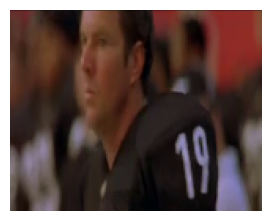

In [3]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 1
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


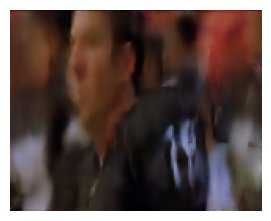

In [4]:
example_idx = 1
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

### 4.2 Generate a GIF

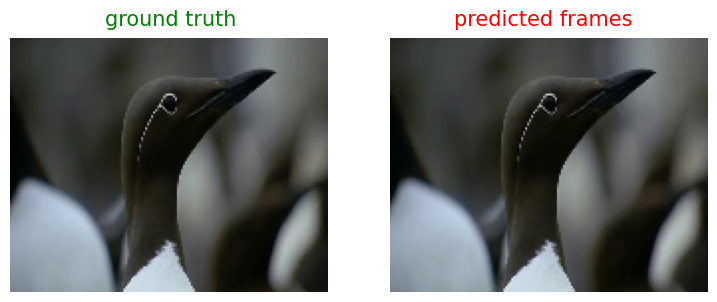

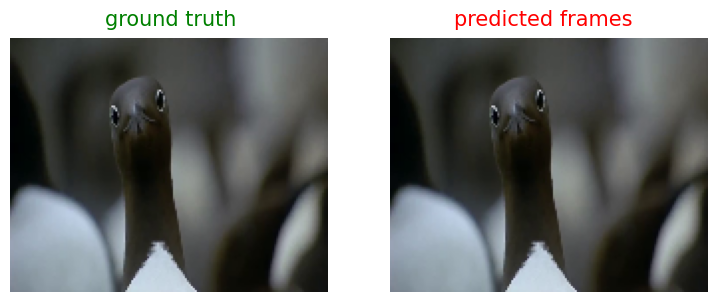

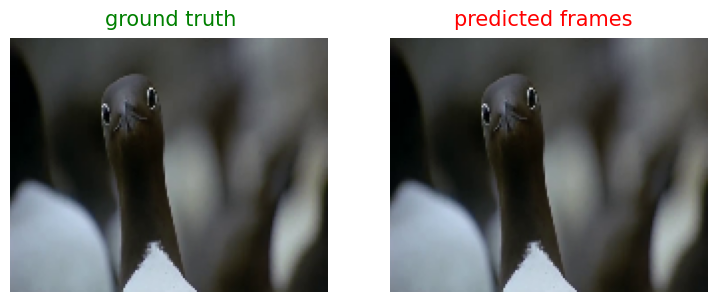

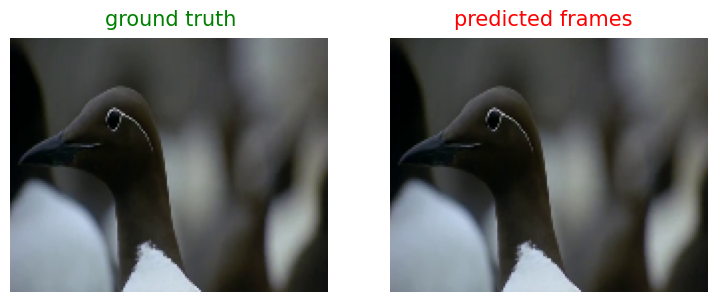

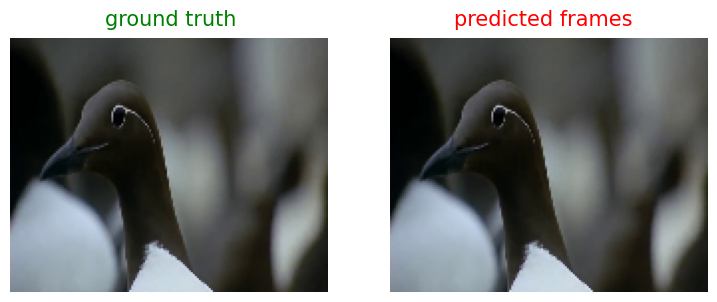

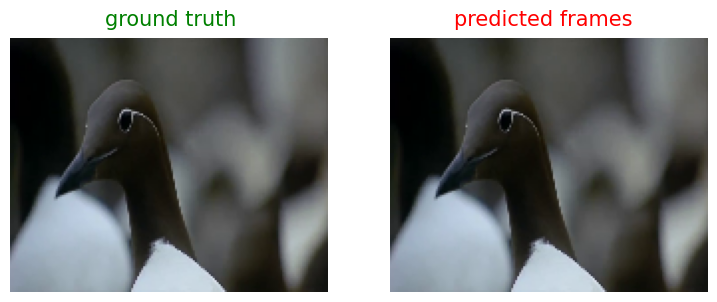

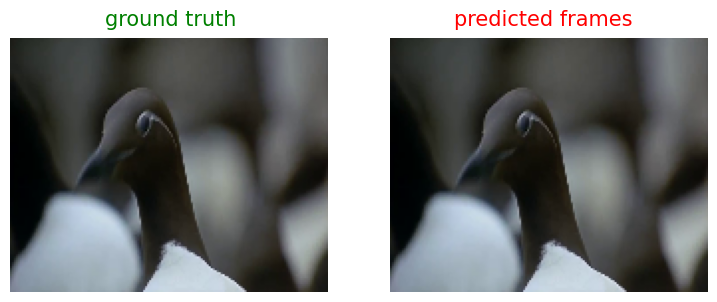

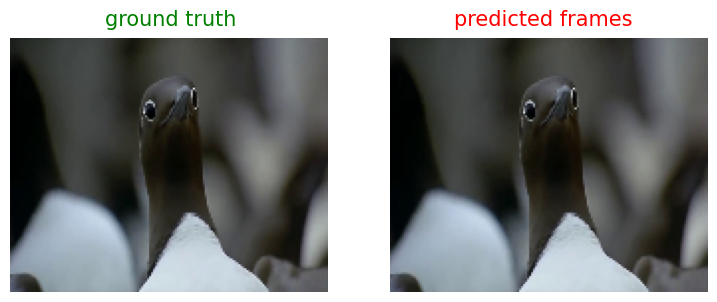

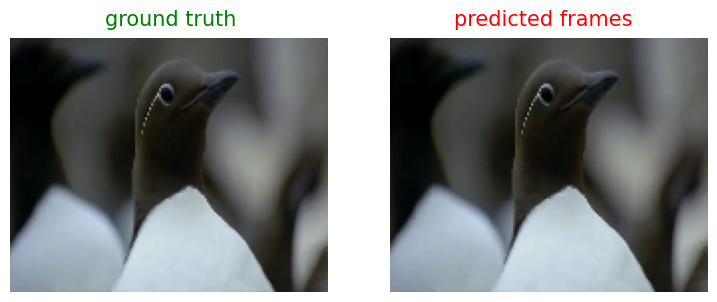

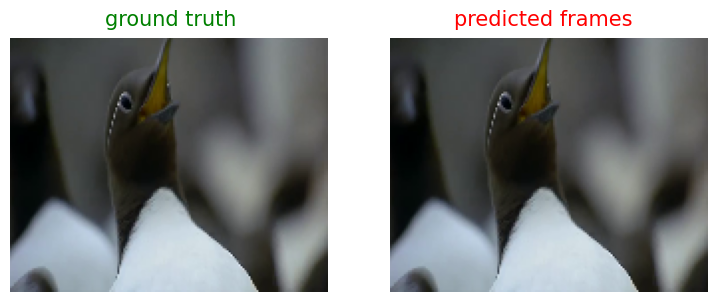

In [142]:
from openstl.utils import show_video_gif_multiple
example_idx = 9
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')

/home/jaslap/.conda/envs/OpenSTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


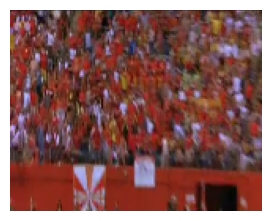

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


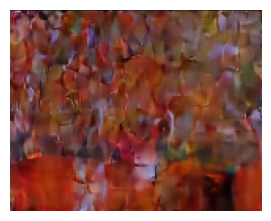

({'mse': 0.005652229, 'mae': 0.03128367}, 'mse:0.005652228835970163, mae:0.0312836691737175')
({'mse': 0.005815859, 'mae': 0.031149529}, 'mse:0.005815858952701092, mae:0.031149528920650482')


In [24]:
from openstl.core import metric

example_idx = 27
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

H, W = 128, 160

print(metric(trues[example_idx], preds[example_idx], spatial_norm=True))
print(metric(trues[example_idx][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], preds[example_idx][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], spatial_norm=True))

Center bias information of  60  examples
Average value of mse:  0.009591896
Average value of mse_center:  0.010907945
Average value of psnr:  17.80653019278022
Average value of psnr_center:  18.57647986544863
Average value of mae:  0.036503926
Average value of mae_center:  0.038349822
Standard deviation of mse:  0.010583226
Standard deviation of mse_center:  0.016558789
Standard deviation of psnr:  4.538380148041973
Standard deviation of psnr_center:  5.494436224494217
Standard deviation of mae:  0.02356106
Standard deviation of mae_center:  0.029696139
Full metric:  ({'mse': 0.02877569, 'mae': 0.109511785, 'psnr': 17.712728365280917}, 'mse:0.028775690123438835, mae:0.10951178520917892, psnr:17.712728365280917')


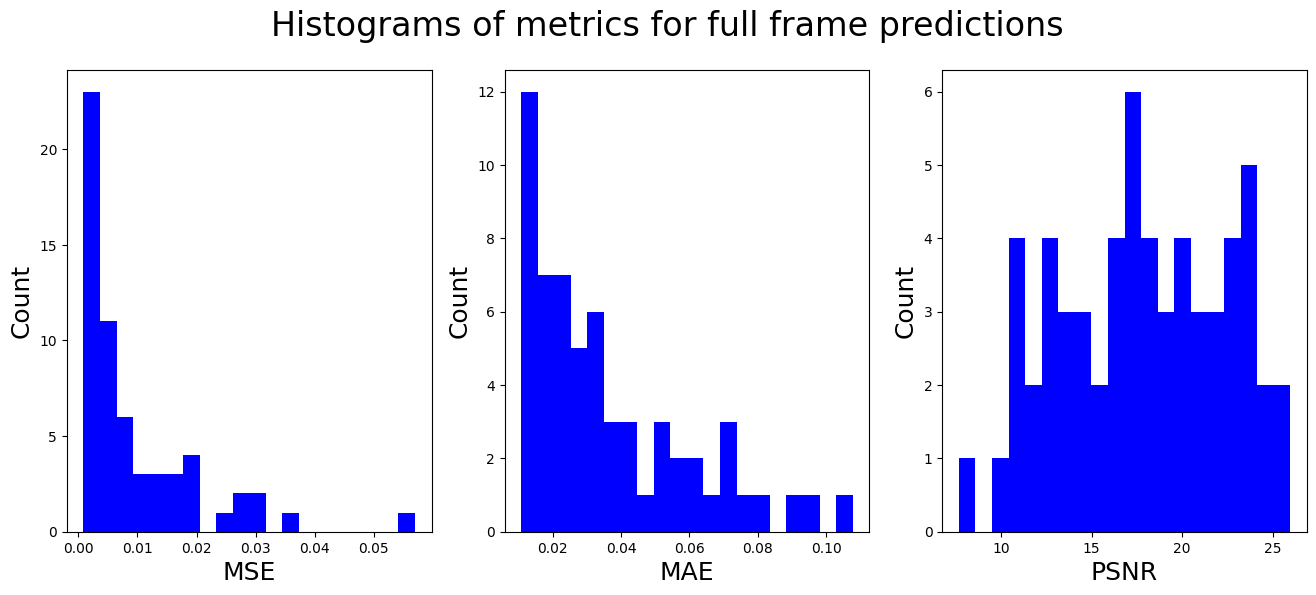

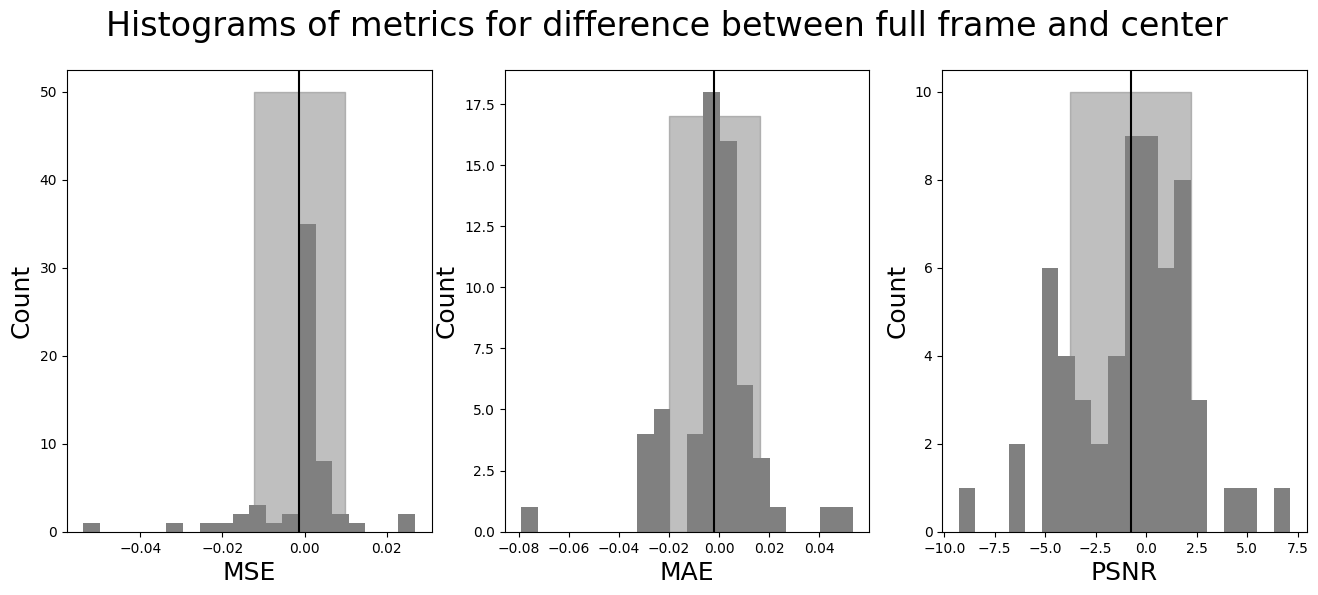

In [138]:
import matplotlib.pyplot as plt
mse = []
mse_center = []
psnr = []
psnr_center = []
mae = []
mae_center = []
for i in range (len(preds)):
    mse.append(metric(trues[i], preds[i], spatial_norm=True, metrics=['mse'])[0]['mse'])
    mse_center.append(metric(trues[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], preds[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], spatial_norm=True, metrics=['mse'])[0]['mse'])
    psnr.append(metric(trues[i], preds[i], spatial_norm=True, metrics=['psnr'])[0]['psnr'])
    psnr_center.append(metric(trues[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], preds[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], spatial_norm=True, metrics=['psnr'])[0]['psnr'])
    mae.append(metric(trues[i], preds[i], spatial_norm=True, metrics=['mae'])[0]['mae'])
    mae_center.append(metric(trues[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], preds[i][ :, :, int(0.375*H):int(0.625*H) :, int(0.375*W):int(0.625*W)], spatial_norm=True, metrics=['mae'])[0]['mae'])

mse_diff = np.array(mse) - np.array(mse_center)
psnr_diff = np.array(psnr) - np.array(psnr_center)
mae_diff = np.array(mae) - np.array(mae_center)

print("Center bias information of ", len(preds), " examples")
print("Average value of mse: ", np.mean(mse))
print("Average value of mse_center: ", np.mean(mse_center))
print("Average value of psnr: ", np.mean(psnr))
print("Average value of psnr_center: ", np.mean(psnr_center))
print("Average value of mae: ", np.mean(mae))
print("Average value of mae_center: ", np.mean(mae_center))
print("Standard deviation of mse: ", np.std(mse))
print("Standard deviation of mse_center: ", np.std(mse_center))
print("Standard deviation of psnr: ", np.std(psnr))
print("Standard deviation of psnr_center: ", np.std(psnr_center))
print("Standard deviation of mae: ", np.std(mae))
print("Standard deviation of mae_center: ", np.std(mae_center))
# print("Mean difference between squared errors: ", np.mean(mse_diff))
# print("Max difference between squared errors: ", np.max(mse_diff))
# print("Mean difference between psnr: ", np.mean(psnr_diff))
# print("Max difference between psnr: ", np.max(psnr_diff))
# print("Mean difference between mae: ", np.mean(mae_diff))
# print("Max difference between mae: ", np.max(mae_diff))
print("Full metric: ", metric(trues, preds, spatial_norm=True, metrics=['mse', 'psnr', 'mae']))

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Histograms of metrics for full frame predictions', fontsize=24)
axes[0].hist(mse, bins=20, color='b')
axes[0].set_xlabel('MSE', fontsize = 18)
axes[0].set_ylabel('Count', fontsize = 18)
axes[1].hist(mae, bins=20, color='b')
axes[1].set_xlabel('MAE', fontsize = 18)
axes[1].set_ylabel('Count', fontsize = 18)
axes[2].hist(psnr, bins=20, color='b')
axes[2].set_xlabel('PSNR', fontsize = 18)
axes[2].set_ylabel('Count', fontsize = 18)
plt.show()

fix, axes = plt.subplots(1, 3, figsize=(16, 6))
fix.suptitle('Histograms of metrics for difference between full frame and center', fontsize=24)

axes[0].hist(mse_diff, bins=20, color='gray')
axes[0].axvline(x=np.mean(mse_diff), color='k')
axes[0].fill_between([np.mean(mse_diff) - np.std(mse_diff), np.mean(mse_diff) + np.std(mse_diff)], 0, 50, color='gray', alpha=0.5)
axes[0].set_xlabel('MSE', fontsize = 18)
axes[0].set_ylabel('Count', fontsize = 18)

axes[1].hist(mae_diff, bins=20, color='gray')
axes[1].axvline(x=np.mean(mae_diff), color='k')
axes[1].fill_between([np.mean(mae_diff) - np.std(mae_diff), np.mean(mae_diff) + np.std(mae_diff)], 0, 17, color='gray', alpha=0.5)
axes[1].set_xlabel('MAE', fontsize = 18)
axes[1].set_ylabel('Count', fontsize = 18)

axes[2].hist(psnr_diff, bins=20, color='gray')
axes[2].axvline(x=np.mean(psnr_diff), color='k')
axes[2].fill_between([np.mean(psnr_diff) - np.std(psnr_diff), np.mean(psnr_diff) + np.std(psnr_diff)], 0, 10, color='gray', alpha=0.5)
axes[2].set_xlabel('PSNR', fontsize = 18)
axes[2].set_ylabel('Count', fontsize = 18)

plt.show()

In [50]:
# Below is an example of how to get the values of the metrics for a single scene, this has been done multiple times by hand as there does not exist a mapping of 
# video to index. The video is SUND_36a_POR-Scene-001.mp4 

from scipy.io import loadmat
import cv2
import numpy as np

loaded = loadmat('../eyeCoords/coords206.mat', squeeze_me=True)
coords206 = loaded['etAll']

# print(coords206.shape)

video206_scene001 = cv2.VideoCapture('/home/jaslap/OpenSTL/data/gaze_test/test/SUND_36a_POR-Scene-001.mp4')
frame_count = int(video206_scene001.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count:", frame_count)

frame_idxs = np.linspace(0, frame_count - 1, 11, dtype=int)

mse_full = metric(trues[6], preds[6], spatial_norm=True, metrics=['mse'])[0]['mse']
psnr_full = metric(trues[6], preds[6], spatial_norm=True, metrics=['psnr'])[0]['psnr']
mae_full = metric(trues[6], preds[6], spatial_norm=True, metrics=['mae'])[0]['mae']

# print(mse_full)

# print(preds[6].shape)

coords = coords206[frame_idxs[-1]]

coords_resized = coords
coords_resized[:, 0] = coords_resized[:, 0] / 2560 * W
coords_resized[:, 1] = coords_resized[:, 1] / 1440 * H

coords_resized = coords_resized.astype(int)

# print(coords_resized)

mse = 0
mae = 0
psnr = 0

for coord in coords_resized:
    mse += metric(trues[6][:, :, coord[1]:, coord[0]], preds[6][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['mse'])[0]['mse']
    mae += metric(trues[6][:, :, coord[1]:, coord[0]], preds[6][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['mae'])[0]['mae']
    psnr += metric(trues[6][:, :, coord[1]:, coord[0]], preds[6][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['psnr'])[0]['psnr']

mse = mse / len(coords_resized)
mae = mae / len(coords_resized)
psnr = psnr / len(coords_resized)
print(" mse: ", mse, " mse_full: ", mse_full, "mse diff: ", mse_full - mse)
print(" mae: ", mae, " mae_full: ", mae, "mae diff: ", mae_full - mae)
print(" psnr: ", psnr, " psnr_full: ", psnr_full, "psnr diff: ", psnr_full - psnr)

Frame count: 68
 mse:  0.005962091363342432  mse_full:  0.0040333574 mse diff:  -0.001928733992697624
 mae:  0.03349754786790174  mae_full:  0.03349754786790174 mae diff:  -0.008790908518441137
 psnr:  17.92390741377403  psnr_full:  19.298738426581874 psnr diff:  1.3748310128078423


In [136]:
from scipy.io import loadmat
import cv2
import numpy as np
loaded = loadmat('../eyeCoords/coords77.mat', squeeze_me=True)
coords77 = loaded['etAll']

video = cv2.VideoCapture('/home/jaslap/OpenSTL/data/gaze_test/test/WINGE_21a-Scene-007.mp4')
offset = 679
frame_count = offset + int(video.get(cv2.CAP_PROP_FRAME_COUNT) / 2.5)
print("frame count:", frame_count)

frame_idxs = np.linspace(offset, frame_count - 1, 11, dtype=int)

video_idx = 15
print("video index:", video_idx)

coords = coords77[frame_idxs[-1]-1]

coords_resized = coords
coords_resized[:, 0] = coords_resized[:, 0] / 2560 * W
coords_resized[:, 1] = coords_resized[:, 1] / 1440 * H

coords_resized = coords_resized.astype(int)

mse = 0
mae = 0
psnr = 0

for coord in coords_resized:
    mse += metric(trues[video_idx][:, :, coord[1]:, coord[0]], preds[video_idx][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['mse'])[0]['mse']
    mae += metric(trues[video_idx][:, :, coord[1]:, coord[0]], preds[video_idx][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['mae'])[0]['mae']
    psnr += metric(trues[video_idx][:, :, coord[1]:, coord[0]], preds[video_idx][:, :, coord[1]:, coord[0]], spatial_norm=True, metrics=['psnr'])[0]['psnr']

mse = mse / len(coords_resized)
mae = mae / len(coords_resized)
psnr = psnr / len(coords_resized)
print("mse: ", mse, "mae: ", mae, "psnr: ", psnr)

frame count: 719
video index: 15
mse:  0.004056250328122748 mae:  0.0247751374674194 psnr:  20.038840078090892


Average value of mse:  0.014535043173696232
Average value of mae:  0.03650250836570149
Average value of psnr:  19.397089410983366
Standard deviation of mse:  0.045179634822532184
Standard deviation of mae:  0.025233493007977476
Standard deviation of psnr:  5.441440873363834


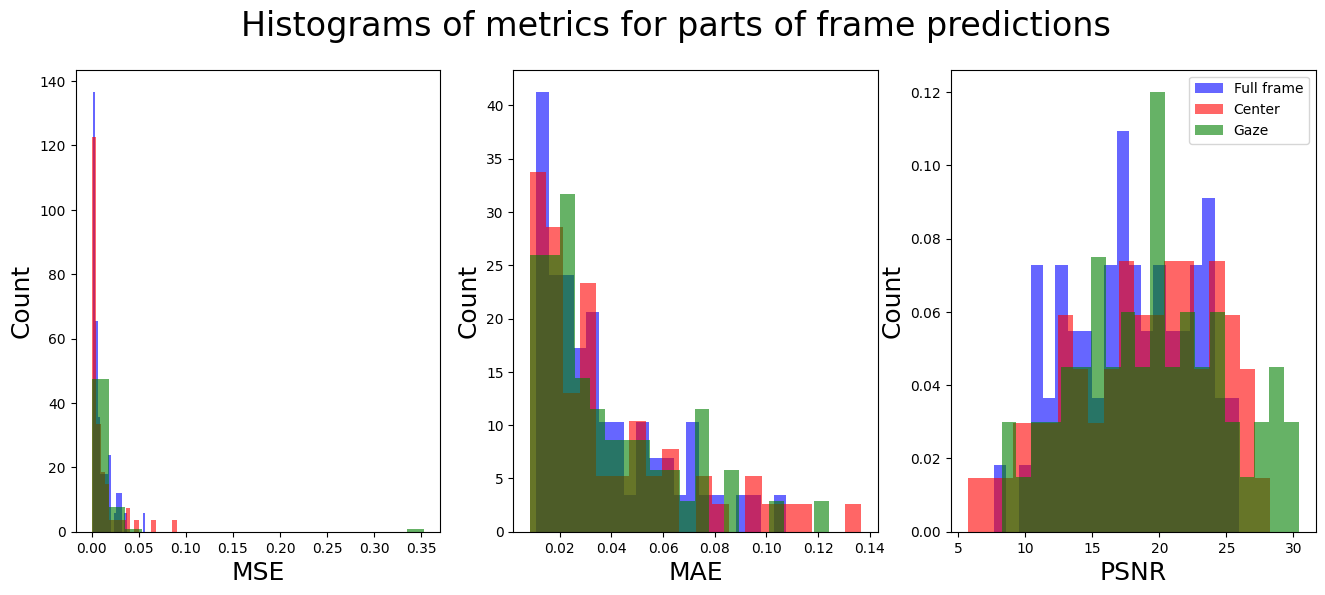

0.008804215030269916


In [144]:
import pandas as pd
gaze_results = pd.read_csv('/home/jaslap/OpenSTL/examples/eyecoord_prediction_metrics.csv')
print("Average value of mse: ", np.mean(gaze_results['mse']))
print("Average value of mae: ", np.mean(gaze_results['mae']))
print("Average value of psnr: ", np.mean(gaze_results['psnr']))
print("Standard deviation of mse: ", np.std(gaze_results['mse']))
print("Standard deviation of mae: ", np.std(gaze_results['mae']))
print("Standard deviation of psnr: ", np.std(gaze_results['psnr']))
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Histograms of metrics for parts of frame predictions', fontsize=24)

axes[0].hist(mse, bins=20, color='b', alpha=0.6, label='Full frame', density=True)
axes[0].hist(mse_center, bins=20, color='r', alpha=0.6, label='Center', density=True)
axes[0].hist(gaze_results['mse'], bins=20, color='g', alpha=0.6, label='Gaze', density=True)

axes[0].set_xlabel('MSE', fontsize = 18)
axes[0].set_ylabel('Count', fontsize = 18)

axes[1].hist(mae, bins=20, color='b', alpha=0.6, label='Full frame', density=True)
axes[1].hist(mae_center, bins=20, color='r', alpha=0.6, label='Center', density=True)
axes[1].hist(gaze_results['mae'], bins=20, color='g', alpha=0.6, label='Gaze', density=True)

axes[1].set_xlabel('MAE', fontsize = 18)
axes[1].set_ylabel('Count', fontsize = 18)

axes[2].hist(psnr, bins=20, color='b', alpha=0.6, label='Full frame', density=True)
axes[2].hist(psnr_center, bins=20, color='r', alpha=0.6, label='Center', density=True)
axes[2].hist(gaze_results['psnr'], bins=20, color='g', alpha=0.6, label='Gaze', density=True)

axes[2].set_xlabel('PSNR', fontsize = 18)
axes[2].set_ylabel('Count', fontsize = 18)

plt.legend()
plt.show()
print(gaze_results.drop(gaze_results[gaze_results['index'] == 9].index).mean()['mse'])

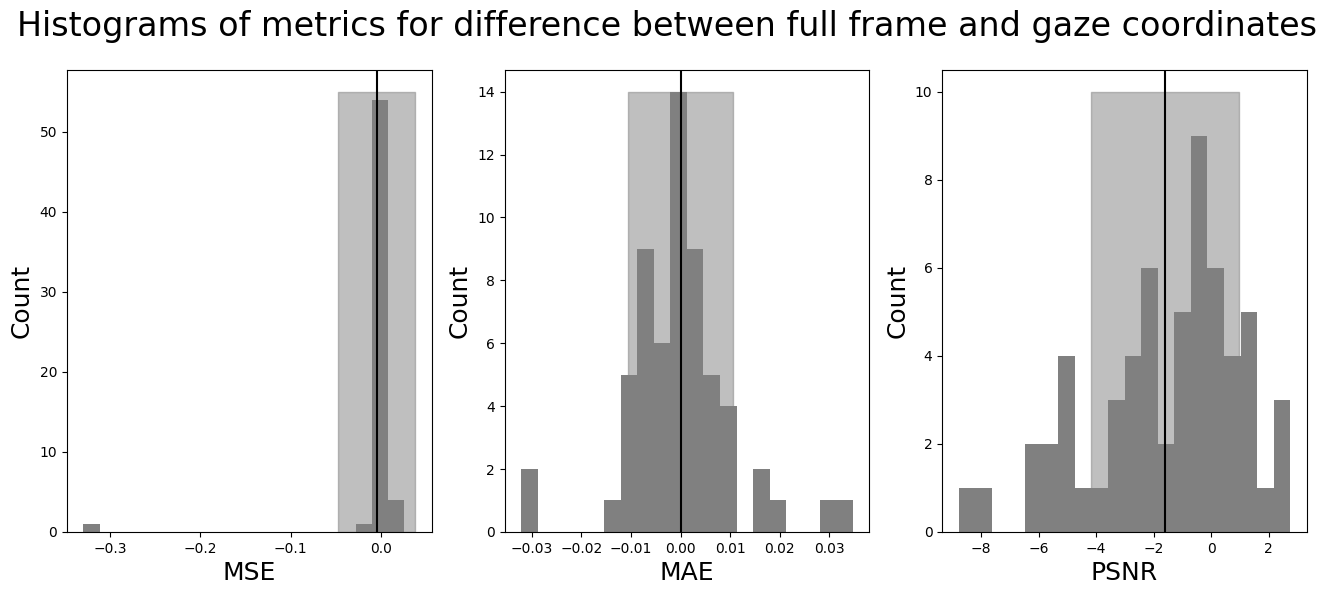

In [147]:
gaze_results_sorted = gaze_results.sort_values(by=['index'])

mse_diff = mse - gaze_results_sorted['mse']
mae_diff = mae - gaze_results_sorted['mae']
psnr_diff = psnr - gaze_results_sorted['psnr']

fix, axes = plt.subplots(1, 3, figsize=(16, 6))
fix.suptitle('Histograms of metrics for difference between full frame and gaze coordinates', fontsize=24)

axes[0].hist(mse_diff, bins=20, color='gray')
axes[0].axvline(x=np.mean(mse_diff), color='k')
axes[0].fill_between([np.mean(mse_diff) - np.std(mse_diff), np.mean(mse_diff) + np.std(mse_diff)], 0, 55, color='gray', alpha=0.5)
axes[0].set_xlabel('MSE', fontsize = 18)
axes[0].set_ylabel('Count', fontsize = 18)

axes[1].hist(mae_diff, bins=20, color='gray')
axes[1].axvline(x=np.mean(mae_diff), color='k')
axes[1].fill_between([np.mean(mae_diff) - np.std(mae_diff), np.mean(mae_diff) + np.std(mae_diff)], 0, 14, color='gray', alpha=0.5)
axes[1].set_xlabel('MAE', fontsize = 18)
axes[1].set_ylabel('Count', fontsize = 18)

axes[2].hist(psnr_diff, bins=20, color='gray')
axes[2].axvline(x=np.mean(psnr_diff), color='k')
axes[2].fill_between([np.mean(psnr_diff) - np.std(psnr_diff), np.mean(psnr_diff) + np.std(psnr_diff)], 0, 10, color='gray', alpha=0.5)
axes[2].set_xlabel('PSNR', fontsize = 18)
axes[2].set_ylabel('Count', fontsize = 18)

plt.show()

In [418]:
import os
dataset = "/home/jaslap/OpenSTL/data/gaze_test/"
folder = "test"
folder_path = os.path.join(dataset, folder)
files = os.listdir(folder_path)
frame_count = 0
print(coords78.shape)
for file in files:
    if file.startswith("WINGE_3a") and file.endswith(".mp4"):
        video_path = os.path.join(folder_path, file)
        video = cv2.VideoCapture(video_path)
        frame_count += int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        print(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if file.startswith("WINGE_3a") and file.endswith(".mov"):
        video_path = os.path.join(folder_path, file)
        video = cv2.VideoCapture(video_path)
        print(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count/720)

(720,)
0.0
597.0
210.0
472.0
298.0
223.0
